<a href="https://colab.research.google.com/github/dmgutierrez/webis-clickbait-detector/blob/main/webis_clickbait_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Webis Clickbait Evaluation

In [1]:
!pip install transformers[torch]
!pip install datasets

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 880 kB 45.5 MB/s 
     |████████████████████████████████| 77 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 6.6 MB 33.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=aebc68afbebd4ddcad1db341697329904bb0b205ee5a21ee8185938e6a0482af
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 212 kB 44.5 MB/s 
     |████████████████████████████████| 136 kB 55.0 MB/s 
     |████████████████████████████████| 1.1 MB 46.5 MB/s 
     |██████████████████████████████

In [28]:
import pandas as pd 
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from collections import Counter
import matplotlib.pyplot as plt


In [46]:
# Load Training Data
webis_train = pd.read_csv('webis_train.csv')
webis_train.head()

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,0,[],UK’s response to modern slavery leaving victim...,858462320779026432,['modern-slavery-rex.jpg'],['Thousands of modern slavery victims have\xa0...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,"modern slavery, Department For Work And Pensio...",“Inexcusable” failures in the UK’s system for ...,"[0.33333333330000003, 0.0, 0.33333333330000003...",0.133333,no-clickbait,0.000000,0.000000
1,1,[],this is good,858421020331560960,"['In this July 1, 2010 file photo, Dr. Charmai...",['President Donald Trump has appointed the\xa0...,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,"Americans United for Life, Dr. Charmaine Yoest...",President Donald Trump has appointed pro-life ...,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000,clickbait,1.000000,1.000000
2,2,[],"The ""forgotten"" Trump roast: Relive his brutal...",858368123753435136,"[""President Trump will not attend this year's ...",['When the\xa0White House correspondents’ dinn...,The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,"trump whcd, whcd, white house correspondents d...",President Trump won't be at this year's White ...,"[0.33333333330000003, 1.0, 0.33333333330000003...",0.466667,no-clickbait,0.333333,0.333333
3,3,[],Meet the happiest #dog in the world!,858323428260139008,"['Maru ', 'Maru', 'Maru', 'Maru', 'Maru']",['Adorable is probably an understatement. This...,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,"Maru, husky, dogs, pandas, furball, instagram","The article is about Maru, a husky dog who has...","[1.0, 0.6666666666000001, 1.0, 1.0, 1.0]",0.933333,clickbait,1.000000,1.000000
4,4,[],Tokyo's subway is shut down amid fears over an...,858283602626347008,"[""All nine lines of Tokyo's subway system were...","[""One of Tokyo's major subways systems says it...",Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,"Tokyo,subway,shut,fears,North,Korean,attack","The temporary suspension, which lasted ten min...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000


In [278]:
webis_train_smpl = webis_train.copy()
cols = ["postText", "truthClass"]
webis_train_smpl = webis_train_smpl[cols]
webis_train_smpl.head()

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [279]:
webis_train_smpl.postText.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [280]:
print(webis_train_smpl.shape)
webis_train_smpl.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)
print(webis_train_smpl.shape)


(19538, 2)
(19484, 2)


In [281]:
# Checkout number of elements per class

freqs_target = Counter(webis_train_smpl[['truthClass']].values.flatten().tolist()
)
freqs_target

Counter({'clickbait': 4716, 'no-clickbait': 14768})

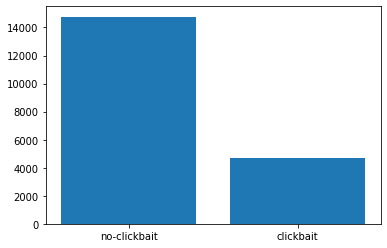

In [257]:
plt.bar(freqs_target.keys(), freqs_target.values())

plt.show()

In [ ]:
# It is clear that the dataset is totally unbalanced and it should be considered when training the model

## Create Dataset from csv

Let's modify the target from strings to numeric data where the positive class (0) will be clickbait and the negative class (1) will be no-clickbait.

In [282]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

le = preprocessing.LabelEncoder()

In [283]:
target_num = le.fit_transform(webis_train_smpl['truthClass'])
target_num

array([1, 0, 1, ..., 1, 1, 1])

In [284]:
le.classes_

array(['clickbait', 'no-clickbait'], dtype=object)

In [285]:
le.transform(["clickbait", "clickbait", "no-clickbait"])

array([0, 0, 1])

In [286]:
webis_train_smpl['truthClass_label'] = target_num
webis_train_smpl.head()

,postText,truthClass,truthClass_label
0,UKs response to modern slavery leaving victims...,no-clickbait,1
1,this is good,clickbait,0
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,1
3,Meet the happiest #dog in the world!,clickbait,0
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,1


In [288]:
webis_train_smpl.rename(columns = {'truthClass_label':'labels', 'postText': 'text'}, inplace = True)
webis_train_smpl['labels'] = webis_train_smpl['labels'].astype("int")
webis_train_smpl['text'] = webis_train_smpl['text'].astype("string")

webis_train_smpl.head()

,text,truthClass,labels
0,UKs response to modern slavery leaving victims...,no-clickbait,1
1,this is good,clickbait,0
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,1
3,Meet the happiest #dog in the world!,clickbait,0
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,1


In [264]:
#texts_data_lst = webis_train_smpl['text'].values.tolist() #values
#texts_data = [[i] for i in texts_data_lst if i is not None]
#texts_data[0:5]

In [214]:
#webis_train_smpl['text'] = texts_data
#webis_train_smpl.head()

,text,labels,truthClass_label
0,[UK’s response to modern slavery leaving victi...,no-clickbait,1
1,[this is good],clickbait,0
2,"[The ""forgotten"" Trump roast: Relive his bruta...",no-clickbait,1
3,[Meet the happiest #dog in the world!],clickbait,0
4,[Tokyo's subway is shut down amid fears over a...,no-clickbait,1


In [289]:
webis_clickbait_train, webis_clickbait_eval = train_test_split(webis_train_smpl, test_size=0.3, stratify=webis_train_smpl['labels'])
webis_clickbait_train.shape, webis_clickbait_eval.shape

((13638, 3), (5846, 3))

In [290]:
tds = Dataset.from_pandas(webis_clickbait_train)
vds = Dataset.from_pandas(webis_clickbait_eval)
tds, vds

(Dataset({
     features: ['text', 'truthClass', 'labels', '__index_level_0__'],
     num_rows: 13638
 }), Dataset({
     features: ['text', 'truthClass', 'labels', '__index_level_0__'],
     num_rows: 5846
 }))

In [291]:
ds = DatasetDict()

ds['train'] = tds
ds['validation'] = vds

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'truthClass', 'labels', '__index_level_0__'],
        num_rows: 13638
    })
    validation: Dataset({
        features: ['text', 'truthClass', 'labels', '__index_level_0__'],
        num_rows: 5846
    })
})

## Tokenize data

In [292]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

In [293]:
def preprocess_function(samples, colname="text"):
    #print(samples[colname][0])
    return tokenizer(samples[colname], truncation=True,padding=True)

In [294]:
tokenized_sentences_1 = tokenizer(ds["train"]["text"][0], truncation=True)
tokenized_sentences_1

{'input_ids': [101, 2057, 1005, 2128, 2893, 1000, 13730, 2098, 1000, 21209, 2015, 2013, 6554, 2585, 1005, 1055, 2684, 6187, 13793, 2063, 1005, 1055, 2047, 4773, 2186, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [295]:
tokenized_webis_clickbait = ds.map(preprocess_function, batched=True)
tokenized_webis_clickbait

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'truthClass', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 13638
    })
    validation: Dataset({
        features: ['text', 'truthClass', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5846
    })
})

In [296]:
columns_to_return = ['input_ids', 'labels', 'attention_mask']
tokenized_webis_clickbait.set_format(type='torch', columns=columns_to_return)
tokenized_webis_clickbait

DatasetDict({
    train: Dataset({
        features: ['text', 'truthClass', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 13638
    })
    validation: Dataset({
        features: ['text', 'truthClass', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 5846
    })
})

## Load pre-trained model

In [297]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

In [298]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [299]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [300]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_webis_clickbait["train"],
    eval_dataset=tokenized_webis_clickbait["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: truthClass, __index_level_0__, text. If truthClass, __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13638
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4265


Step,Training Loss
500,0.389800
1000,0.326500
1500,0.285800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke